# Compare GP and GE

In [1]:
from elitism import eaSimpleWithElitism
import matplotlib.pyplot as plt
import random

random.seed(42)

## Prepare GE

### House keeping

In [2]:
# change directory to grape 
%cd ../grape

/home/tu/code-py/evolutionary-computation/grape


In [ ]:
from algorithms import ge_eaSimpleWithElitism

In [4]:
# Suppressing Warnings:
import warnings

warnings.filterwarnings("ignore")

In [5]:
# Set parameters

POPULATION_SIZE = 500
MAX_GENERATIONS = 50
P_CROSSOVER = 0.8
P_MUTATION = 0.01
HALLOFFAME_SIZE = max(round(0.01*POPULATION_SIZE), 1) #it should be at least 1
ELITE_SIZE = min(round(0.01*POPULATION_SIZE), HALLOFFAME_SIZE)

CODON_CONSUMPTION = "lazy"
GENOME_REPRESENTATION = "list"
MAX_GENOME_LENGTH = None

MAX_INIT_TREE_DEPTH = 13
MIN_INIT_TREE_DEPTH = 3
MAX_TREE_DEPTH = 35
MAX_WRAPS = 0
CODON_SIZE = 255

REPORT_ITEMS = [
    "gen",
    "invalid",
    "avg",
    "std",
    "min",
    "max",
    "best_ind_length",
    "avg_length",
    "best_ind_nodes",
    "avg_nodes",
    "avg_depth",
    "avg_used_codons",
    "best_ind_used_codons",
    "selection_time",
    "generation_time",
]

In [6]:
# random seed
import random


RANDOM_SEED = 42
random.seed(RANDOM_SEED)

### Data

In [7]:
import numpy as np
import pandas as pd


X_train = np.zeros([4, 16], dtype=bool)
Y_train = np.zeros([16,], dtype=bool)

data = pd.read_table(r"datasets/parity4.csv")
for i in range(4):
    for ii in range(16):
        X_train[i, ii] = data["d" + str(i)].iloc[ii]
for i in range(16):
    Y_train[i] = data["output"].iloc[i]

data

,d0,d1,d2,d3,output
0,0,0,0,0,1
1,0,0,0,1,0
2,0,0,1,0,0
3,0,0,1,1,1
4,0,1,0,0,0
5,0,1,0,1,1
6,0,1,1,0,1
7,0,1,1,1,0
8,1,0,0,0,0
9,1,0,0,1,1


### Gramma

In [8]:
import grape 
from functions import not_, and_, or_, nand_, nor_


GRAMMAR_FILE = "grammars/parity4.bnf"

GRAMMAR = grape.Grammar(GRAMMAR_FILE)
GRAMMAR.production_rules

[[['<op>', 'non-terminal', 1, 0, True, 4],
  ['<x>', 'non-terminal', 1, 1, False, 2]],
 [['and_(<e>,<e>)', 'non-terminal', 2, 0, True, 3],
  ['or_(<e>,<e>)', 'non-terminal', 2, 1, True, 3],
  ['nand_(<e>,<e>)', 'non-terminal', 2, 2, True, 3],
  ['nor_(<e>,<e>)', 'non-terminal', 2, 3, True, 3]],
 [['x[0]', 'terminal', 0, 0, False, 1],
  ['x[1]', 'terminal', 0, 1, False, 1],
  ['x[2]', 'terminal', 0, 2, False, 1],
  ['x[3]', 'terminal', 0, 3, False, 1]]]

### Fitness

In [9]:
def geFitness(ind, points):
    x = points[0]
    Y = points[1]

    if ind.invalid:
        return np.nan,

    try:
        pred = eval(ind.phenotype)
    except (FloatingPointError, ZeroDivisionError, OverflowError, MemoryError):
        return np.nan,
    assert np.isrealobj(pred)

    nSample = len(Y)
    compare = np.equal(Y, pred)
    nCorrect = np.sum(compare)
    
    fitness = nSample - nCorrect
    
    return fitness,

### Toolbox

In [10]:
from deap import creator, base, tools

import grape


geBox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", grape.Individual, fitness=creator.FitnessMin)

geBox.register("populationCreator", grape.sensible_initialisation, creator.Individual)
geBox.register("evaluate", geFitness)
geBox.register("select", tools.selTournament, tournsize=6)
geBox.register("mate", grape.crossover_onepoint)
geBox.register("mutate", grape.mutation_int_flip_per_codon)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

## Prepare GP

In [11]:
# back to normal directory
%cd -

/home/tu/code-py/evolutionary-computation/ES4


### House keeping

In [12]:


MIN_INIT_TREE_HEIGHT = MIN_INIT_TREE_DEPTH
MAX_INIT_TREE_HEIGHT = MAX_INIT_TREE_DEPTH
LIMIT_TREE_HEIGHT = MAX_TREE_DEPTH
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

### Primative Set

In [13]:
import operator
from deap import gp


pset = gp.PrimitiveSet("MAIN", 4)

def opNand(a, b):
    return np.logical_not(np.logical_and(a, b))
def opNor(a, b):
    return np.logical_not(np.logical_or(a, b))

# not_, and_, or_, nand_, nor_
pset.addPrimitive(operator.not_, 1)
pset.addPrimitive(operator.and_, 2)
pset.addPrimitive(operator.or_, 2)
pset.addPrimitive(opNand, 2)
pset.addPrimitive(opNor, 2)

pset.addTerminal(np.bool_(1))
pset.addTerminal(np.bool_(0))

### Fitness

In [14]:
def gpFitness(ind, toolbox, points):
    x,Y = points
    
    func = toolbox.compile(expr=ind)

    try:
        pred = func(*x)
    except Exception:
        return len(Y),

    assert np.isrealobj(pred)

    nSample = len(Y)
    compare = np.equal(Y, pred)
    nCorrect = np.sum(compare)

    fitness = nSample - nCorrect

    return fitness,

### Toolbox

In [15]:
import operator


gpBox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

gpBox.register("expr", gp.genHalfAndHalf, pset=pset, min_=MIN_INIT_TREE_HEIGHT, max_=MAX_INIT_TREE_HEIGHT)
gpBox.register("individualCreator", tools.initIterate, creator.Individual, gpBox.expr)
gpBox.register("populationCreator", tools.initRepeat, list, gpBox.individualCreator)
gpBox.register("compile", gp.compile, pset=pset)
gpBox.register("evaluate", gpFitness, toolbox=gpBox, points=[X_train, Y_train])

gpBox.register("select", tools.selTournament, tournsize=6)
gpBox.register("mate", gp.cxOnePoint)
gpBox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
gpBox.register("mutate", gp.mutUniform, expr=gpBox.expr_mut, pset=pset)

gpBox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
gpBox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))

## Compare 

### 0.8 - 0.01

In [16]:
P_CROSSOVER = 0.8
P_MUTATION = 0.01

#### GP

<ErrorbarContainer object of 3 artists>

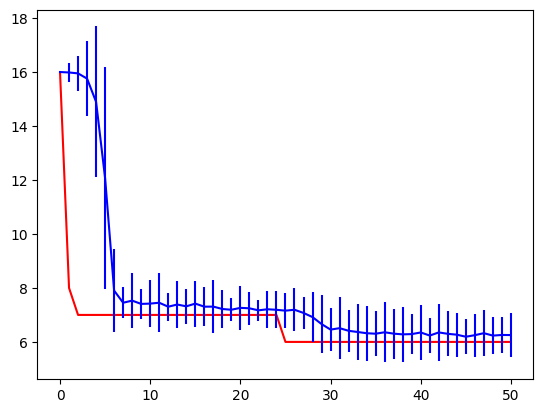

In [17]:
gpPopulation = gpBox.populationCreator(n=POPULATION_SIZE)
gpHof = tools.HallOfFame(HALLOFFAME_SIZE)

gpPopulation, logbook = eaSimpleWithElitism(
    gpPopulation,
    gpBox,
    cxpb=P_CROSSOVER,
    mutpb=P_MUTATION,
    ngen=MAX_GENERATIONS,
    stats=stats,
    halloffame=gpHof,
    verbose=False,
)

maxFitness, meanFitness, stdFitness, minFitness = logbook.select(
    "max", "avg", "std", "min"
)
gen, invalid = logbook.select("gen", "invalid")


plt.figure()
plt.plot(gen, minFitness, label="Best Fitness", color="red")
plt.errorbar(gen, meanFitness, yerr= stdFitness, label="Mean Fitness", color="blue")

#### GE

gen = 0 , Best fitness = (np.float64(6.0),)
gen = 1 , Best fitness = (np.float64(6.0),) , Number of invalids = 87
gen = 2 , Best fitness = (np.float64(6.0),) , Number of invalids = 76
gen = 3 , Best fitness = (np.float64(5.0),) , Number of invalids = 47
gen = 4 , Best fitness = (np.float64(5.0),) , Number of invalids = 38
gen = 5 , Best fitness = (np.float64(5.0),) , Number of invalids = 20
gen = 6 , Best fitness = (np.float64(4.0),) , Number of invalids = 15
gen = 7 , Best fitness = (np.float64(4.0),) , Number of invalids = 13
gen = 8 , Best fitness = (np.float64(4.0),) , Number of invalids = 14
gen = 9 , Best fitness = (np.float64(3.0),) , Number of invalids = 7
gen = 10 , Best fitness = (np.float64(3.0),) , Number of invalids = 11
gen = 11 , Best fitness = (np.float64(3.0),) , Number of invalids = 8
gen = 12 , Best fitness = (np.float64(3.0),) , Number of invalids = 14
gen = 13 , Best fitness = (np.float64(3.0),) , Number of invalids = 6
gen = 14 , Best fitness = (np.float64(3.0),) 

<ErrorbarContainer object of 3 artists>

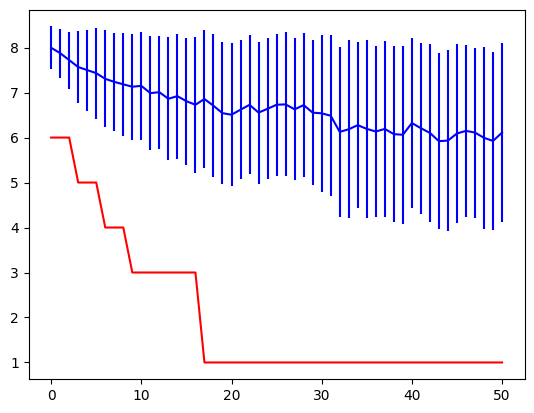

In [18]:


gePopulation = geBox.populationCreator(
    pop_size=POPULATION_SIZE,
    bnf_grammar=GRAMMAR,
    min_init_depth=MIN_INIT_TREE_DEPTH,
    max_init_depth=MAX_INIT_TREE_DEPTH,
    codon_size=CODON_SIZE,
    codon_consumption=CODON_CONSUMPTION,
    genome_representation=GENOME_REPRESENTATION,
)
geHof = tools.HallOfFame(HALLOFFAME_SIZE)

gePopulation, logbook = ge_eaSimpleWithElitism(
    gePopulation,
    toolbox=geBox,
    cxpb=P_CROSSOVER,
    mutpb=P_MUTATION,
    ngen=MAX_GENERATIONS,
    elite_size=ELITE_SIZE,
    bnf_grammar=GRAMMAR,
    codon_size=CODON_SIZE,
    max_tree_depth=MAX_TREE_DEPTH,
    max_genome_length=MAX_GENOME_LENGTH,
    points_train=[X_train, Y_train],
    codon_consumption=CODON_CONSUMPTION,
    report_items=REPORT_ITEMS,
    genome_representation=GENOME_REPRESENTATION,
    stats=stats,
    halloffame=geHof,
    verbose=False,
)

maxFitness, meanFitness, stdFitness, minFitness = logbook.select(
    "max", "avg", "std", "min"
)

plt.figure()
plt.plot(gen, minFitness, label="Best Fitness", color="red")
plt.errorbar(gen, meanFitness, yerr= stdFitness, label="Mean Fitness", color="blue")


### 0.9 - 0.05

In [19]:
P_CROSSOVER = 0.9
P_MUTATION = 0.05

#### GP

<ErrorbarContainer object of 3 artists>

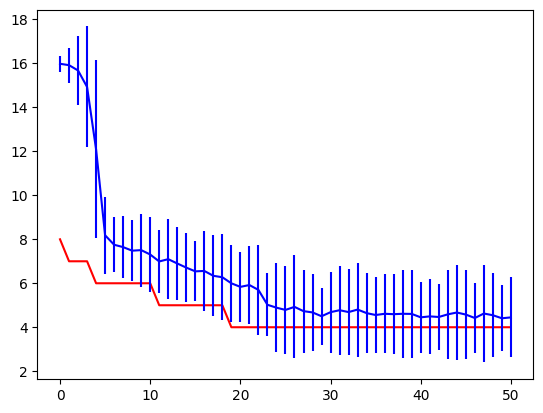

In [20]:
gpPopulation = gpBox.populationCreator(n=POPULATION_SIZE)
gpHof = tools.HallOfFame(HALLOFFAME_SIZE)

gpPopulation, logbook = eaSimpleWithElitism(
    gpPopulation,
    gpBox,
    cxpb=P_CROSSOVER,
    mutpb=P_MUTATION,
    ngen=MAX_GENERATIONS,
    stats=stats,
    halloffame=gpHof,
    verbose=False,
)

maxFitness, meanFitness, stdFitness, minFitness = logbook.select(
    "max", "avg", "std", "min"
)

plt.figure()
plt.plot(gen, minFitness, label="Best Fitness", color="red")
plt.errorbar(gen, meanFitness, yerr= stdFitness, label="Mean Fitness", color="blue")

#### GE

gen = 0 , Best fitness = (np.float64(1.0),)
gen = 1 , Best fitness = (np.float64(1.0),) , Number of invalids = 99
gen = 2 , Best fitness = (np.float64(1.0),) , Number of invalids = 60
gen = 3 , Best fitness = (np.float64(1.0),) , Number of invalids = 35
gen = 4 , Best fitness = (np.float64(1.0),) , Number of invalids = 17
gen = 5 , Best fitness = (np.float64(1.0),) , Number of invalids = 25
gen = 6 , Best fitness = (np.float64(1.0),) , Number of invalids = 19
gen = 7 , Best fitness = (np.float64(1.0),) , Number of invalids = 14
gen = 8 , Best fitness = (np.float64(1.0),) , Number of invalids = 12
gen = 9 , Best fitness = (np.float64(1.0),) , Number of invalids = 4
gen = 10 , Best fitness = (np.float64(1.0),) , Number of invalids = 4
gen = 11 , Best fitness = (np.float64(1.0),) , Number of invalids = 6
gen = 12 , Best fitness = (np.float64(1.0),) , Number of invalids = 4
gen = 13 , Best fitness = (np.float64(1.0),) , Number of invalids = 3
gen = 14 , Best fitness = (np.float64(1.0),) , 

<ErrorbarContainer object of 3 artists>

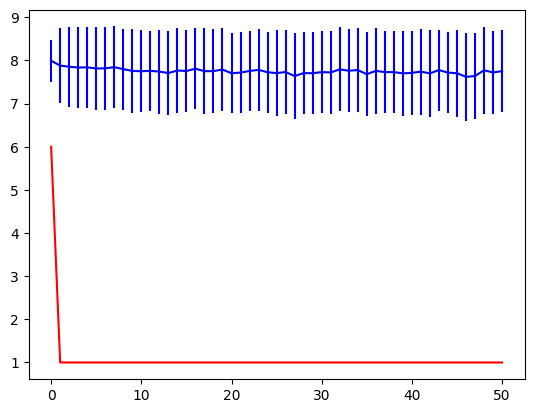

In [21]:
gePopulation = geBox.populationCreator(
    pop_size=POPULATION_SIZE,
    bnf_grammar=GRAMMAR,
    min_init_depth=MIN_INIT_TREE_DEPTH,
    max_init_depth=MAX_INIT_TREE_DEPTH,
    codon_size=CODON_SIZE,
    codon_consumption=CODON_CONSUMPTION,
    genome_representation=GENOME_REPRESENTATION,
)

gePopulation, logbook = ge_eaSimpleWithElitism(
    gePopulation,
    toolbox=geBox,
    cxpb=P_CROSSOVER,
    mutpb=P_MUTATION,
    ngen=MAX_GENERATIONS,
    elite_size=ELITE_SIZE,
    bnf_grammar=GRAMMAR,
    codon_size=CODON_SIZE,
    max_tree_depth=MAX_TREE_DEPTH,
    max_genome_length=MAX_GENOME_LENGTH,
    points_train=[X_train, Y_train],
    codon_consumption=CODON_CONSUMPTION,
    report_items=REPORT_ITEMS,
    genome_representation=GENOME_REPRESENTATION,
    stats=stats,
    halloffame=geHof,
    verbose=False,
)

maxFitness, meanFitness, stdFitness, minFitness = logbook.select(
    "max", "avg", "std", "min"
)

plt.figure()
plt.plot(gen, minFitness, label="Best Fitness", color="red")
plt.errorbar(gen, meanFitness, yerr= stdFitness, label="Mean Fitness", color="blue")


### Text

In both setups, GE shows to be a better algorithm than GP in solving the parity 4 bits problem.
The best fitness is lower and the mean fitness is higher in GE than in GP. 
This implies that GE can not only find better solutions but also explore the search broarder space than GP.